# Resurface the peptides and their interactions with the hinge for the designs which pass alphafold

### Imports

In [1]:
# %load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
# %matplotlib inline
# reloads modules automatically before executing cells
# %load_ext autoreload
# %autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /global/cfs/cdirs/m4129/projects/crispy_shifty_adam/projects/OPS/round_1/design
running on node: login07


### Resurface the predicted states peptides

In [4]:
sys.path.insert(0, "/global/cfs/cdirs/m4129/projects/crispy_shifty_adam")
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "12_resurface_with_hinge"
design_list_file = "/pscratch/sd/b/broerman/11_fold_paired_states_X/folded_paired_states.list"
output_path = f"/pscratch/sd/b/broerman/{simulation_name}"
options = " ".join(
    [
        "out:level 200",
    ]
)

extra_kwargs = {
    "models": "1",
    "clean_disulfides": "true",
    "redesign_hinge": "full_surf",
    "path_to_model_weights": "/global/u2/b/broerman/databases/mpnn/vanilla_model_weights/",
}

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.cleaning.finalize_peptide",
    design_list_file=design_list_file,
    output_path=output_path,
    perlmutter_mode=True,
    # queue="gpu-remote",
    # cores=2,
    # gres="--gres=gpu:a4000:1",
    # memory="10G",
    nstruct=1,
    nstruct_per_task=4,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
    time="1:29:30",
)

Run the following command with your desired environment active:
sbatch -a 1-489 /pscratch/sd/b/broerman/12_resurface_with_hinge/run.sh


In [2]:
# also generate a set with a much more minimal hinge surface redesign

sys.path.insert(0, "/global/cfs/cdirs/m4129/projects/crispy_shifty_adam")
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "12_resurface_with_hinge"
design_list_file = "/pscratch/sd/b/broerman/11_fold_paired_states_X/folded_paired_states.list"
output_path = f"/pscratch/sd/b/broerman/{simulation_name}"
options = " ".join(
    [
        "out:level 200",
    ]
)

extra_kwargs = {
    "models": "1",
    "clean_disulfides": "true",
    "redesign_hinge": "int_surf",
    "path_to_model_weights": "/global/u2/b/broerman/databases/mpnn/vanilla_model_weights/",
}

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.cleaning.finalize_peptide",
    design_list_file=design_list_file,
    output_path=output_path,
    perlmutter_mode=True,
    # queue="gpu-remote",
    # cores=2,
    # gres="--gres=gpu:a4000:1",
    # memory="10G",
    nstruct=1,
    nstruct_per_task=4,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
    time="1:29:30",
)

/global/cfs/cdirs/m4129/projects/crispy_shifty_adam/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Run the following command with your desired environment active:
sbatch -a 1-489 /pscratch/sd/b/broerman/12_resurface_with_hinge/run.sh


In [4]:
with open("/pscratch/sd/b/broerman/12_resurface_with_hinge/resurfaced_with_hinge.list", "w") as f:
    for path in sorted(glob("/pscratch/sd/b/broerman/12_resurface_with_hinge/decoys/*/*.pdb.bz2")):
        print(path, file=f)

In [6]:
sys.path.insert(0, "/global/cfs/cdirs/m4129/projects/crispy_shifty_adam")
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "12_resurface_only_peptide"
design_list_file = "/pscratch/sd/b/broerman/12_resurface_with_hinge/resurfaced_with_hinge.list"
output_path = f"/pscratch/sd/b/broerman/{simulation_name}"
options = " ".join(
    [
        "out:level 200",
    ]
)

extra_kwargs = {
    "models": "1",
    "clean_disulfides": "true",
    "path_to_model_weights": "/global/u2/b/broerman/databases/mpnn/vanilla_model_weights/",
}

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.cleaning.finalize_peptide",
    design_list_file=design_list_file,
    output_path=output_path,
    perlmutter_mode=True,
    # queue="gpu-remote",
    # cores=2,
    # gres="--gres=gpu:a4000:1",
    # memory="10G",
    nstruct=1,
    nstruct_per_task=6,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
    time="1:29:30",
)

Run the following command with your desired environment active:
sbatch -a 1-3402 /pscratch/sd/b/broerman/12_resurface_only_peptide/run.sh


In [3]:
sys.path.insert(0, "/global/cfs/cdirs/m4129/projects/crispy_shifty_adam")

from crispy_shifty.utils.io import collect_score_file

simulation_name = "12_resurface_only_peptide"
output_path = os.path.join("/pscratch/sd/b/broerman/", simulation_name)

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

### Load resulting concatenated scorefile

In [4]:
from crispy_shifty.utils.io import parse_scorefile_linear

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

  0%|          | 0/81421 [00:00<?, ?it/s]

### Dump scores_df as a CSV and then reload, for performance reasons

In [5]:
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

In [9]:
scores_df.sort_values(by="state", inplace=True)

from IPython.display import display
with pd.option_context(
    'display.max_columns', None,
):
    display(scores_df)

,X_mean_pae,X_mean_pae_interaction,X_mean_pae_interaction_AB,X_mean_pae_interaction_BA,X_mean_pae_intra_chain,X_mean_pae_intra_chain_A,X_mean_pae_intra_chain_B,X_mean_plddt,X_model,X_pTMscore,X_recycles,X_rmsd_to_input,X_rmsd_to_reference,X_seed,X_tol,X_type,Y_mean_pae,Y_mean_pae_interaction,Y_mean_pae_interaction_AB,Y_mean_pae_interaction_BA,Y_mean_pae_intra_chain,Y_mean_pae_intra_chain_A,Y_mean_pae_intra_chain_B,Y_mean_plddt,Y_model,Y_pTMscore,Y_recycles,Y_rmsd_to_input,Y_rmsd_to_reference,Y_seed,Y_tol,Y_type,bb_clash,bb_clash_delta,bb_clash_delta_x,buns_parent,chBr1_seq,chBr2_seq,cms_AcB,cms_AnAc,cms_AnAcB,cms_AnB,designed_by,docked_helix,dslf_fa13,dssp,elapsed_time,exposed_hydrophobics_parent,fa_atr,fa_dun,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,fa_intra_elec,fa_intra_rep,fa_intra_rep_xover4,fa_intra_sol_xover4,fa_rep,fa_sol,fixed_resis,geometry_parent,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,holes_all_parent,holes_core_parent,hxl_tors,interface,lk_ball,lk_ball_bridge,lk_ball_bridge_uncpl,lk_ball_iso,lk_ball_wtd,loop_dist,loop_sc,looped_length,mean_pae,mean_pae_interaction,mean_pae_interaction_AB,mean_pae_interaction_BA,mean_pae_intra_chain,mean_pae_intra_chain_A,mean_pae_intra_chain_B,mean_plddt,mismatch_probability_parent,model,mpnn_design_area,mpnn_msd_design_area,mpnn_msd_temperature,mpnn_temperature,new_loop_str,omega,pTMscore,p_aa_pp,packstat_parent,parent,parent_length,path_in,pdb,pivot_helix,pre_break_helix,pro_close,rama_prepro,recycles,redesign_hinge,ref,repeat_len,res_type_constraint,rmsd_to_input,rmsd_to_reference,sap_parent,sc_AcB,sc_AnAc,sc_AnAcB,sc_AnB,sc_all_parent,score,score_per_res,score_per_res_parent,score_per_res_x,seed,shift,ss_sc,state,time,tol,topo,total_length,total_score,trim_n,trimmed_length,type,yhh_planarity,cms
/pscratch/sd/b/broerman/12_resurface_only_peptide/decoys/0042/12_resurface_only_peptide_e50fdf18df9045388dc82ba3312e1b10.pdb.bz2,3.616271,3.782732,3.490175,4.075289,3.033057,3.465083,2.601031,93.459511,1,0.853824,3.0,1.276315,0.538541,0,0.131298,monomer_ptm,3.323090,3.255971,3.239090,3.272853,2.661566,3.304072,2.019060,94.510300,1,0.871517,3.0,1.276315,0.219884,0,0.138030,monomer_ptm,858.278992,3.366442,98.119438,0.0,SREELKKLIEELLETAREGLLKILDEEK,SREELKELIDELLETARKGLLAILDREK,258.545898,237.754028,704.916931,444.446594,mpnn,3,0.0,LHHHHHHHHHHHHHHHHHHHLLLHHHHHHHHHHHHHHHHHHLLHHH...,5.992561,561.615540,-2437.055987,770.008875,56.990195,264.916775,469.893229,-763.757984,-139.352923,-97.588752,823.121376,113.622243,79.540452,3491.143981,1647.678955,"28,29,32,35,36,39,71,72,75,78,79,82,117,118,12...",1.0,-15.292780,-7.689935,-18.861911,-327.022098,0.189760,-0.516379,22.212212,normal,1240.438896,6.896952,47.375009,2970.933363,-46.393874,12.181629,0.733430,175.0,3.323090,3.255971,3.239090,3.272853,2.661566,3.304072,2.019060,94.510300,0.266143,1,neighborhood,neighborhood,0.2,0.1,"85,86,87,88,89",73.581632,0.871517,-117.054387,0.498479,KWH1_chainA_01,172,/home/broerman/crispy_shifty/projects/OPS/roun...,/home/broerman/crispy_shifty/projects/OPS/roun...,4,4,10.099228,-144.457584,3.0,int_surf,45.60699,43,0.0,1.276315,0.219884,18.355696,0.663160,0.763239,0.756508,0.780153,0.619305,-1142.033209,-2.792257,-2.580300,-1.978358,0,-3,0.721999,KWH1_chainA_01_p_4_s_-3_d_3,2017.246359,0.138030,HHHHHHHH,206.0,526.820981,0,172,monomer_ptm,7.434564e-07,595.916626
/pscratch/sd/b/broerman/12_resurface_only_peptide/decoys/0006/12_resurface_only_peptide_c86b581e0e8c4331b76572e553ff19ef.pdb.bz2,3.364380,3.418681,3.197244,3.640119,2.701658,3.310856,2.092461,94.762573,1,0.857860,3.0,1.360762,0.548678,0,0.182559,monomer_ptm,3.365224,3.419445,3.199403,3.639487,2.703109,3.311843,2.094376,94.758408,1,0.858099,3.0,1.360762,0.022729,0,0.194327,monomer_ptm,858.278992,0.735644,26.359375,0.0,SLEEMFEIAKEALKLLKEAKRKELEEAE,X,415.515137,148.466843,903.478760,517.100037,mpnn,3,0.0,LHHHHHHHHHHHHHHHHHHHLLLHHHHHHHHHHHHHHHHHHLLHHH...,77.400940,561.615540,-2503.840643,757.019584,61.374979,280.973073,454.119450,-7

2it [00:00,  8.87it/s]


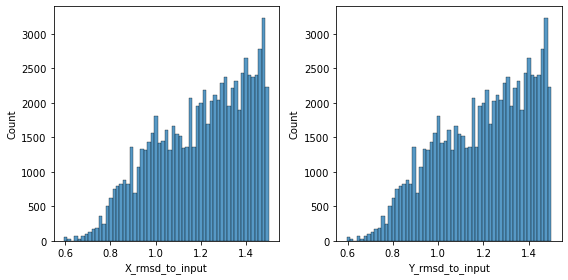

In [10]:
sys.path.insert(0, "/global/cfs/cdirs/m4129/projects/crispy_shifty_adam")
from crispy_shifty.utils.plotting import histplot_df

cols = [
    "X_rmsd_to_input",
    "Y_rmsd_to_input",
]
the_fig = histplot_df(
    df=scores_df,
    cols=cols,
)

In [24]:
from IPython.display import display
with pd.option_context(
    'display.max_rows', None,
):
    display(scores_df.state.value_counts())
scores_df.state.nunique()

P09_2_strand_p_4_s_4_d_5        20472
P09_2_strand_p_4_s_4_d_3         5156
P09_2_strand_p_5_s_-4_d_4        3899
P09_2_strand_p_4_s_-3_d_5        3841
KWH1_chainA_01_p_4_s_4_d_3       3597
RRN_s202_p_5_s_-1_d_6            3560
s25_p_7_s_3_d_8                  3330
R6ST3_p_7_s_-4_d_8               3131
P09_2_strand_p_5_s_3_d_4         3111
R6_n6_p_7_s_-4_d_8               2737
P09_2_strand_p_5_s_3_d_6         2579
s8_LRT6_p_7_s_-4_d_8             2184
sl_S2_08_p_7_s_-4_d_8            1897
KW_b1_11_DY_p_5_s_3_d_6          1606
R6_PO11_p_6_s_6_d_5              1598
KW_b1_11_DY_p_5_s_-1_d_6         1506
KW_b1_11_DY_p_5_s_7_d_4          1382
P09_2_strand_p_4_s_1_d_5         1378
KW_b1_11_DY_p_4_s_-3_d_3         1159
KW_b1_11_DY_p_4_s_1_d_3          1015
P09_2_strand_p_5_s_2_d_6          972
R6_PO11_p_7_s_-3_d_6              962
sl_S2_06_p_5_s_-1_d_4             923
RRN_s202_p_5_s_-5_d_6             922
P09_2_strand_p_4_s_-3_d_3         856
P09_2_strand_p_5_s_-4_d_6         758
KWH1_chainA_

80

### Do some light filtering

6it [00:11,  1.91s/it]


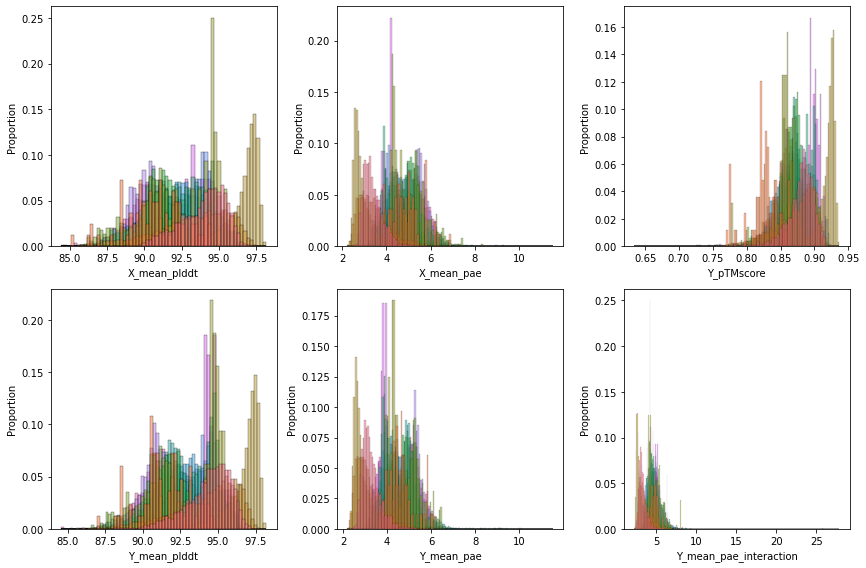

In [21]:
# plot all filtering metrics
filtering_cols = [
    "X_mean_plddt",
    "X_mean_pae",
    "Y_pTMscore",
    "Y_mean_plddt",
    "Y_mean_pae",
    "Y_mean_pae_interaction",
]
the_fig = histplot_df(
    df=scores_df,
    cols=filtering_cols,
    hue="parent",
    stat="proportion",
    common_norm=False,
    legend=False,
)

Each color looks pretty well-spread, so this filtering strategy should work reasonably well with the hard cutoffs directly below.

In [27]:
filtered_df = scores_df.query("X_mean_plddt > 85 and X_mean_pae < 8 and Y_pTMscore > 0.75 and Y_mean_plddt > 85 and Y_mean_pae < 8 and Y_mean_pae_interaction < 9")

filtering_cols = [
    "X_mean_plddt",
    "X_mean_pae",
    "Y_pTMscore",
    "Y_mean_plddt",
    "Y_mean_pae",
    "Y_mean_pae_interaction",
]
minimize_cols = [True, False, True, False, False, True, True, True]

target_representation = 1000

all_states = set(filtered_df.state.values)
state_dfs = []
for state in tqdm(all_states):
    state_df = filtered_df[filtered_df.state == state]

    if len(state_df) > target_representation:
        # find the 10 designs which have all filtering metrics above the quantile cutoff
        filtering_df = pd.DataFrame(columns=filtering_cols)
        for col, minimize in zip(filtering_cols, minimize_cols):
            if minimize:
                filtering_df[col] = -state_df[col]
            else:
                filtering_df[col] = state_df[col]

        df_len = len(filtering_df)
        q = 0.5
        min_q = 0
        max_q = 1
        n_iter = 0
        while df_len != target_representation:
            filtered_quantile_df = filtering_df[filtering_df > filtering_df.quantile(q)].dropna()
            df_len = len(filtered_quantile_df)
            if n_iter > 100:
                # if it's impossible to distinguish among designs, just take the best 10 by X plddt
                filtered_quantile_df = filtering_df[filtering_df > filtering_df.quantile(min_q)].dropna().sort_values(by="X_mean_plddt", ascending=False).head(target_representation)
                print("iteration limit reached")
                break
            if df_len < target_representation:
                max_q = q
                q = (max_q + min_q) / 2
            elif df_len > target_representation:
                min_q = q
                q = (max_q + min_q) / 2
            n_iter += 1
        
        state_df = state_df.loc[filtered_quantile_df.index, :]

    state_dfs.append(state_df)

filtered_df = pd.concat(state_dfs)

  0%|          | 0/79 [00:00<?, ?it/s]

iteration limit reached


In [28]:
from IPython.display import display
with pd.option_context(
    'display.max_rows', None,
):
    display(filtered_df.state.value_counts())
filtered_df.state.nunique()

P09_2_strand_p_5_s_-4_d_4       1000
KW_b1_11_DY_p_4_s_1_d_3         1000
P09_2_strand_p_4_s_4_d_5        1000
R6_n6_p_7_s_-4_d_8              1000
RRN_s202_p_5_s_-1_d_6           1000
s25_p_7_s_3_d_8                 1000
KW_b1_11_DY_p_4_s_-3_d_3        1000
P09_2_strand_p_5_s_3_d_6        1000
KW_b1_11_DY_p_5_s_-1_d_6        1000
P09_2_strand_p_5_s_3_d_4        1000
R6ST3_p_7_s_-4_d_8              1000
P09_2_strand_p_4_s_4_d_3        1000
sl_S2_08_p_7_s_-4_d_8           1000
KW_b1_11_DY_p_5_s_3_d_6         1000
KW_b1_11_DY_p_5_s_7_d_4         1000
P09_2_strand_p_4_s_-3_d_5       1000
R6_PO11_p_6_s_6_d_5             1000
P09_2_strand_p_4_s_1_d_5        1000
s8_LRT6_p_7_s_-4_d_8            1000
KWH1_chainA_01_p_4_s_4_d_3      1000
P09_2_strand_p_5_s_2_d_6         968
R6_PO11_p_7_s_-3_d_6             957
RRN_s202_p_5_s_-5_d_6            921
sl_S2_06_p_5_s_-1_d_4            916
P09_2_strand_p_4_s_-3_d_3        855
P09_2_strand_p_5_s_-4_d_6        758
KWH1_chainA_01_p_4_s_-3_d_3      700
R

79

### Save a list of outputs

In [29]:
with open(os.path.join(output_path, "resurfaced_states.list"), "w") as f:
    for path in tqdm(filtered_df.index):
        print(path, file=f)

  0%|          | 0/32238 [00:00<?, ?it/s]

In [32]:
# bin the outputs and save as pairs
# necessary to avoid padding, which superfold's initial gues does not support

import pyrosetta
import pyrosetta.distributed.io as io

pyrosetta.distributed.maybe_init(
    **{
        "options": "-corrections::beta_nov16 true",
        "extra_options": {"-out:level": "100"},
    }
)

import bz2
from collections import defaultdict
from more_itertools import chunked

length_to_fname = defaultdict(list)

for index, row in tqdm(filtered_df.iterrows()):
    if row["chBr1_seq"] != "X":
        # this will speed this up considerably since we won't have to parse a pdb to get the length
        length = int(row["looped_length"]) + len(row["chBr1_seq"])
    else:
        with open(index, "rb") as f:  # read bz2 bytestream, decompress and decode
            pose = io.to_pose(io.pose_from_pdbstring(bz2.decompress(f.read()).decode()))
        length = pose.chain_end(2)
    
    length_to_fname[length].append(index)

with open(os.path.join(output_path, "resurfaced_states.pair"), "w") as f:
    for fnames_by_len in length_to_fname.values():
        for fname_chunk in chunked(fnames_by_len, 10):
            print("____".join(fname_chunk), file=f)

0it [00:00, ?it/s]